<a href="https://colab.research.google.com/github/tripti8377/Inter-IIT-Bootcamp_Quant/blob/main/Quant_PS_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install pandas_ta
import pandas_ta as ta

In [ ]:
# Download the historical price data for NIFTY 50 stocks
nifty_50_tickers = [
    "RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", "TCS.NS",
    "KOTAKBANK.NS", "ITC.NS", "LT.NS", "HINDUNILVR.NS", "SBIN.NS",
    "BHARTIARTL.NS", "BAJFINANCE.NS", "ASIANPAINT.NS", "DMART.NS",
    "MARUTI.NS", "AXISBANK.NS", "HCLTECH.NS", "M&M.NS", "ULTRACEMCO.NS",
    "TITAN.NS", "SUNPHARMA.NS", "ONGC.NS", "WIPRO.NS", "ADANIENT.NS",
    "NTPC.NS", "POWERGRID.NS", "INDUSINDBK.NS", "TATASTEEL.NS", "BAJAJFINSV.NS",
    "DIVISLAB.NS", "JSWSTEEL.NS", "TECHM.NS", "HDFCLIFE.NS", "CIPLA.NS",
    "BPCL.NS", "APOLLOHOSP.NS", "BRITANNIA.NS", "COALINDIA.NS", "HEROMOTOCO.NS",
    "DRREDDY.NS", "TATAMOTORS.NS", "GRASIM.NS", "SBILIFE.NS", "EICHERMOT.NS",
    "UPL.NS", "NESTLEIND.NS", "SHREECEM.NS", "ADANIPORTS.NS", "BPCL.NS"
]

# Download historical data from Yahoo Finance
start_date = "2019-01-01"
end_date = "2023-12-01"
data = yf.download(nifty_50_tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  48 of 48 completed


In [ ]:
data.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [ ]:
data_2 = yf.download(nifty_50_tickers, start=start_date, end=end_date)['Volume']

[*********************100%***********************]  48 of 48 completed


#MOMENTUM_SCORES FUNCTION

In [ ]:
# Momentum score calculation function
def calculate_momentum_score(data,data_2):
    momentum_scores = pd.DataFrame()

    # Loop through each stock's data
    for ticker in data.columns:

        if ticker not in nifty_50_tickers:
            continue
        try:
          stock_close = data[ticker]
        except KeyError:
          continue

        if len(stock_close) < 21:
            continue

        rsi = ta.rsi(stock_close, length=14)
        SMA = data[ticker].rolling(20).mean()
        StdDev = data[ticker].rolling(20).std()
        Bollinger_Upper = SMA + 2 * StdDev
        Bollinger_Lower = SMA- 2 * StdDev
        volatility = stock_close.pct_change().rolling(window=21).std() * np.sqrt(252)
        evma = ta.ema(data_2[ticker], length=20)

        # Normalization of technical indicators
        normalized_rsi = rsi / 100

        #Bollinger Band Score to account for price changes
        normalized_bb_score = (stock_close - Bollinger_Lower) / (Bollinger_Upper - Bollinger_Lower)

        bb_rsi_score = 0.5*normalized_rsi + 0.5*normalized_bb_score/(normalized_bb_score + normalized_rsi)

        # Volatility score
        volatility_score = 1 / (1 + np.exp(volatility))  #if volatility decreases the  score will increase

        # Normalization of evma
        normalized_evma = np.log10(evma +1)/4  #the value of evma can go as high as 10,000 i.e, log value can go as high as 4
                                                    # So it divided by 4

        momentum_scores[ticker] = bb_rsi_score * volatility_score * normalized_evma
        momentum_scores = momentum_scores.iloc[21:]


    return momentum_scores

#STRATEGY FOR TRADING

In [ ]:
start_date_2 = "2019-01-01"
end_date_2 = "2023-12-01"

# 4. Initialize trading variables

long_stock = None
short_stock = None
capital = 1000000  # Initial capital
portfolio_value = capital  # Portfolio value
trading_days = pd.date_range(start=start_date_2, end=end_date_2, freq='B')  # Business days without timezone

# Initialize long and short positions dictionaries
long_positions = {}
short_positions = {}

# Initialize a list to store portfolio value over time
portfolio_history = []

# 5. Initialize positions with 50% of capital each
long_position_size = capital * 0.5
short_position_size = capital * 0.5

# 6. Track entry prices for long and short positions
long_entry_price = None
short_entry_price = None

# 7. Loop through trading days
for date in trading_days:
    # Check if data is available for the current date
    data.index = data.index.tz_localize(None)
    data_2.index = data_2.index.tz_localize(None)
    if date not in data.index:
        portfolio_history.append(portfolio_value)
        continue

    # Calculate momentum scores
    momentum_scores = calculate_momentum_score(data.loc[:date],data_2.loc[:date])

    # Check if momentum scores are empty
    if momentum_scores.empty:
        portfolio_history.append(portfolio_value)
        continue

    final_momentum_scores = momentum_scores.iloc[-1].sort_values(ascending=False)

    # Select new long and short positions if not initialized
    if long_stock is None and short_stock is None:
        long_stock = final_momentum_scores.index[0]  # Stock with highest momentum
        short_stock = final_momentum_scores.index[-1]  # Stock with lowest momentum

        # Capture the entry prices
        long_entry_price = data[long_stock].loc[date]  # Price when entering long
        short_entry_price = data[short_stock].loc[date]  # Price when entering short

        print(f"Initial Long Position: {long_stock} at {long_entry_price}, Initial Short Position: {short_stock} at {short_entry_price}")
        long_positions[long_stock] = {'entry_price': long_entry_price, 'position_size': long_position_size}
        short_positions[short_stock] = {'entry_price': short_entry_price, 'position_size': short_position_size}

    # Ensure long_stock and short_stock are valid before accessing them
    if long_stock is not None and short_stock is not None:
        # Get new rankings
        new_long_stock_rank = final_momentum_scores.index.get_loc(long_stock) + 1
        new_short_stock_rank = final_momentum_scores.index.get_loc(short_stock) + 1

        # Long position: Check if long stock drops below 3rd rank
        if new_long_stock_rank > 3:
            print(f"Exit long position on {long_stock} at {data[long_stock].loc[date]}")
            long_exit_value = long_position_size * (data[long_stock].loc[date] / long_entry_price)  # Value at exit
            portfolio_value += (long_exit_value - long_position_size)  # Update portfolio value
            long_stock = final_momentum_scores.index[0]  # New long stock
            long_entry_price = data[long_stock].loc[date]  # Capture new entry price
            long_position_size = portfolio_value * 0.5  # Reallocate half of portfolio to long
            print(f"Enter new long position on {long_stock} at {long_entry_price}")
            long_positions[long_stock]={'entry_price': long_entry_price, 'position_size': long_position_size}

        # Short position: Check if short stock rises above 3rd from the bottom
        if new_short_stock_rank < (len(final_momentum_scores) - 2):
            print(f"Exit short position on {short_stock} at {data[short_stock].loc[date]}")
            short_exit_value = short_position_size * (short_entry_price / data[short_stock].loc[date])  # Value at exit
            portfolio_value += (short_exit_value - short_position_size)  # Update portfolio value
            short_stock = final_momentum_scores.index[-1]  # New short stock
            short_entry_price = data[short_stock].loc[date]  # Capture new entry price
            short_position_size = portfolio_value * 0.5  # Reallocate half of portfolio to short
            print(f"Enter new short position on {short_stock} at {short_entry_price}")
            short_positions[short_stock] = {'entry_price': short_entry_price, 'position_size': short_position_size}

    for stock in list(long_positions.keys()):
      try:
        long_exit_price = data[stock].loc[date]
        entry_price = long_positions[stock]['entry_price']
        position_size = long_positions[stock]['position_size']
      except KeyError:
        continue

         # Check if the price has dropped by 5% (stop-loss condition)
      if (long_exit_value / long_entry_price) < 0.95:  # Stop-loss of 5%
        profit = (long_exit_value - long_entry_price) * (long_position_size / long_entry_price)
        portfolio_value += profit
        print(f"{date.date()}: Stop-loss triggered for long position on {long_stock} at ₹{long_exit_value:.2f} | Profit/Loss: ₹{profit:.2f}")
        try:
          del long_positions[long_stock]
        except KeyError:
          continue

    for stock in list(short_positions.keys()):
      try:
        short_exit_price = data[stock].loc[date]
        entry_price = short_positions[stock]['entry_price']
        position_size = short_positions[stock]['position_size']

      except KeyError:
        continue

        # Check if the price has risen by 5% (stop-loss condition)
        if (short_exit_value / short_entry_price) > 1.05:  # Stop-loss of 5%
            profit = short_position_size * (short_entry_price / short_exit_value - 1)
            portfolio_value += profit
            print(f"{date.date()}: Stop-loss triggered for short position on {short_stock} at ₹{short_exit_value:.2f} | Profit/Loss: ₹{profit:.2f}")
            try:
                del short_positions[short_stock]
            except KeyError:
                continue

    # Update portfolio history
    portfolio_history.append(portfolio_value)

# After the loop, print the final portfolio value
print(f"Final Portfolio Value: ₹{portfolio_value:.2f}")
print(f"Final Long Position: {long_stock} at {long_entry_price}, Final Short Position: {short_stock} at {short_entry_price}")


Initial Long Position: WIPRO.NS at 285.0636901855469, Initial Short Position: TITAN.NS at 1069.054443359375
Exit long position on WIPRO.NS at 260.0391540527344
Enter new long position on TITAN.NS at 1063.7305908203125
Exit short position on TITAN.NS at 1063.7305908203125
Enter new short position on TATASTEEL.NS at 18.84573745727539
Exit long position on TITAN.NS at 1065.908447265625
Enter new long position on UPL.NS at 600.2078857421875
Exit long position on UPL.NS at 583.3792114257812
Enter new long position on WIPRO.NS at 258.76593017578125
Exit long position on WIPRO.NS at 253.574951171875
Enter new long position on TCS.NS at 1988.549560546875
Exit long position on TCS.NS at 1933.8731689453125
Enter new long position on UPL.NS at 546.176513671875
Exit short position on TATASTEEL.NS at 14.766416549682617
Enter new short position on TITAN.NS at 1075.5863037109375
Exit short position on TITAN.NS at 1220.0657958984375
Enter new short position on SUNPHARMA.NS at 374.8661193847656
Exit lo

# PERFORMANCE METRICS

PROFIT

In [ ]:
print("Initial value of portfolio: ", portfolio_history[0])
print("Final value of portfolio: ", portfolio_history[-1])
print("Profit: ", portfolio_history[-1] - portfolio_history[0])

Initial value of portfolio:  1000000
Final value of portfolio:  2158491.6643285584
Profit:  1158491.6643285584


ROI

In [ ]:
def calculate_roi(portfolio_history):

    beginning_value = portfolio_history[0]
    ending_value = portfolio_history[-1]

    try:
        roi = ((ending_value - beginning_value) / beginning_value) * 100
        return roi
    except ZeroDivisionError:
        return "Beginning value cannot be zero."

# Example usage
roi = calculate_roi(portfolio_history)
print(f"The ROI of your portfolio over the past 5 years is: {roi:.2f}%")

The ROI of your portfolio over the past 5 years is: 115.85%


ANNUALISED VOLATILITY

In [ ]:
def calculate_volatility(portfolio_history):

    # Calculate daily/periodic returns
    returns = [((portfolio_history[i] - portfolio_history[i-1]) / portfolio_history[i-1])
               for i in range(1, len(portfolio_history))]

    # Calculate standard deviation of returns (Volatility)
    volatility = np.std(returns) * np.sqrt(252)  # Annualized volatility if daily data

    return volatility

# Example usage
volatility_overall = calculate_volatility(portfolio_history)
print(f"The annualized volatility of your portfolio over the past 5 years is: {volatility_overall:.4f}")

The annualized volatility of your portfolio over the past 5 years is: 0.2629


SHARPE RATIO

In [ ]:
def calculate_sharpe_ratio(portfolio_history, risk_free_rate=0.07365/252):

    # Calculate daily/periodic returns
    returns = [((portfolio_history[i] - portfolio_history[i-1]) / portfolio_history[i-1])
               for i in range(1, len(portfolio_history))]

    # Calculate average return and volatility (standard deviation of returns)
    average_return = sum(returns) / 252
    volatility = np.std(returns)

    # Calculate the Sharpe ratio (annualized if daily returns)
    sharpe_ratio = (average_return - risk_free_rate) / (volatility)

    return sharpe_ratio

# Example usage
sharpe_ratio = calculate_sharpe_ratio(portfolio_history)
print(f"The Sharpe ratio of your portfolio over the past 5 years is: {sharpe_ratio:.4f}")

The Sharpe ratio of your portfolio over the past 5 years is: 0.2054


SORTINO RATIO

In [ ]:
def calculate_sortino_ratio(portfolio_history, risk_free_rate=0.07365/252):

    # Calculate daily/periodic returns
    returns = [((portfolio_history[i] - portfolio_history[i-1]) / portfolio_history[i-1])
               for i in range(1, len(portfolio_history))]

    # Calculate the average return
    average_return = np.mean(returns)

    # Calculate downside deviation (only returns below risk-free rate)
    downside_returns = [r for r in returns if r < (risk_free_rate)]

    # If no downside returns exist, downside deviation is 0, Sortino ratio is undefined
    if len(downside_returns) == 0:
        return "No downside returns, cannot calculate Sortino ratio."

    downside_deviation = np.std(downside_returns)

    # Calculate the Sortino ratio (annualized for daily data)
    sortino_ratio = (average_return - (risk_free_rate)) / (downside_deviation)

    return sortino_ratio

# Example usage
sortino_ratio = calculate_sortino_ratio(portfolio_history, risk_free_rate=0.07365/252)
print(f"The Sortino ratio of your portfolio over the past 5 years is: {sortino_ratio:.4f}")


The Sortino ratio of your portfolio over the past 5 years is: 0.0662


MAX DRAWDOWN

In [ ]:
# Convert portfolio history to a Pandas DataFrame for easier manipulation
portfolio_history_df = pd.DataFrame(portfolio_history, index=trading_days, columns=["Portfolio Value"])

# Calculate the running maximum (peak) of the portfolio value over time
running_max = portfolio_history_df['Portfolio Value'].cummax()

# Calculate the drawdown at each point: difference between the peak and current portfolio value
drawdown = portfolio_history_df['Portfolio Value'] - running_max

# Calculate drawdown percentage
drawdown_percent = drawdown / running_max

# Maximum drawdown is the minimum of the drawdown percentage
max_drawdown = drawdown_percent.min()

# Print the maximum drawdown value
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

Maximum Drawdown: -25.72%


#VISUALIZATION OF VARIOUS DATA POINTS

PORTFOLIO VALUE WITH TIME

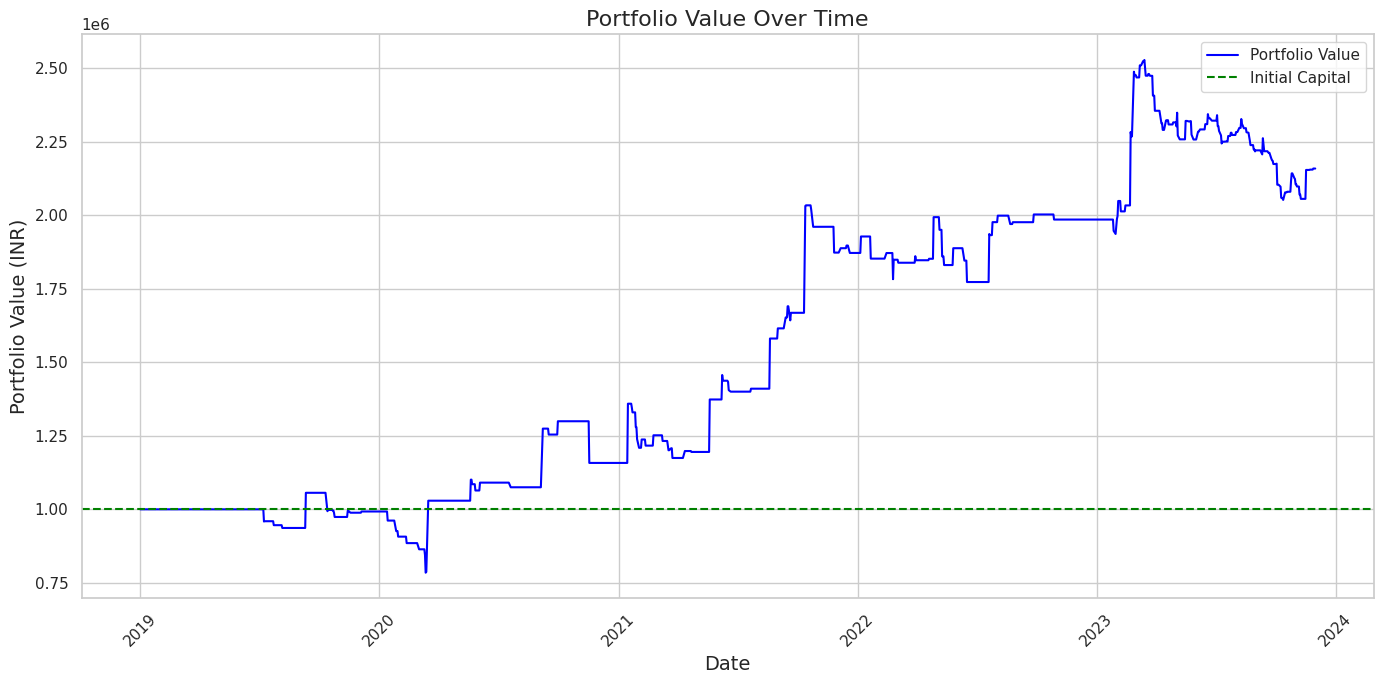

In [ ]:
import matplotlib.pyplot as plt

# Convert the portfolio history list to a DataFrame
portfolio_df = pd.DataFrame({'Portfolio Value': portfolio_history}, index=trading_days)

# Set the plot size for better readability
plt.figure(figsize=(14, 7))

# Plot the Portfolio Value
plt.plot(portfolio_df.index, portfolio_df['Portfolio Value'], label='Portfolio Value', color='blue')

# Highlighting the Initial Capital
plt.axhline(y=capital, color='green', linestyle='--', label='Initial Capital')

# Adding Titles and Labels
plt.title('Portfolio Value Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Portfolio Value (INR)', fontsize=14)

# Adding a Legend
plt.legend()

# Enhancing the X-axis for better date representation
plt.xticks(rotation=45)
plt.tight_layout()

# Display the Plot
plt.show()


PORTFOLIO DRAWDOWN WITH TIME

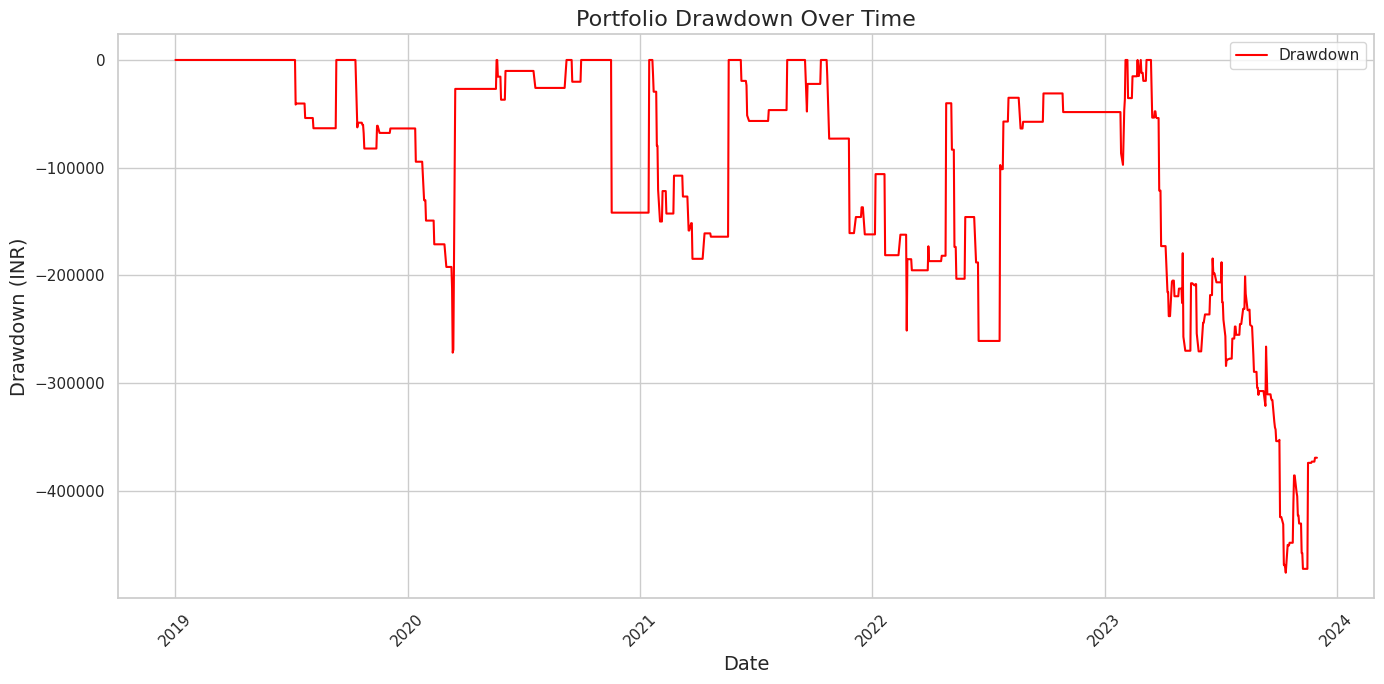

In [ ]:
# Calculate the running maximum (peak) of the portfolio value over time
running_max = portfolio_df['Portfolio Value'].cummax()

# Calculate the drawdown: difference between the peak and current portfolio value
drawdown = portfolio_df['Portfolio Value'] - running_max

# Plot the Drawdown over time
plt.figure(figsize=(14, 7))
plt.plot(drawdown, label='Drawdown', color='red')

# Add title and labels
plt.title('Portfolio Drawdown Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Drawdown (INR)', fontsize=14)

# Rotate x-axis for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend
plt.legend()

# Show the plot
plt.show()


PORTFOLIO CUMMALTIVE RETURNS WITH TIME

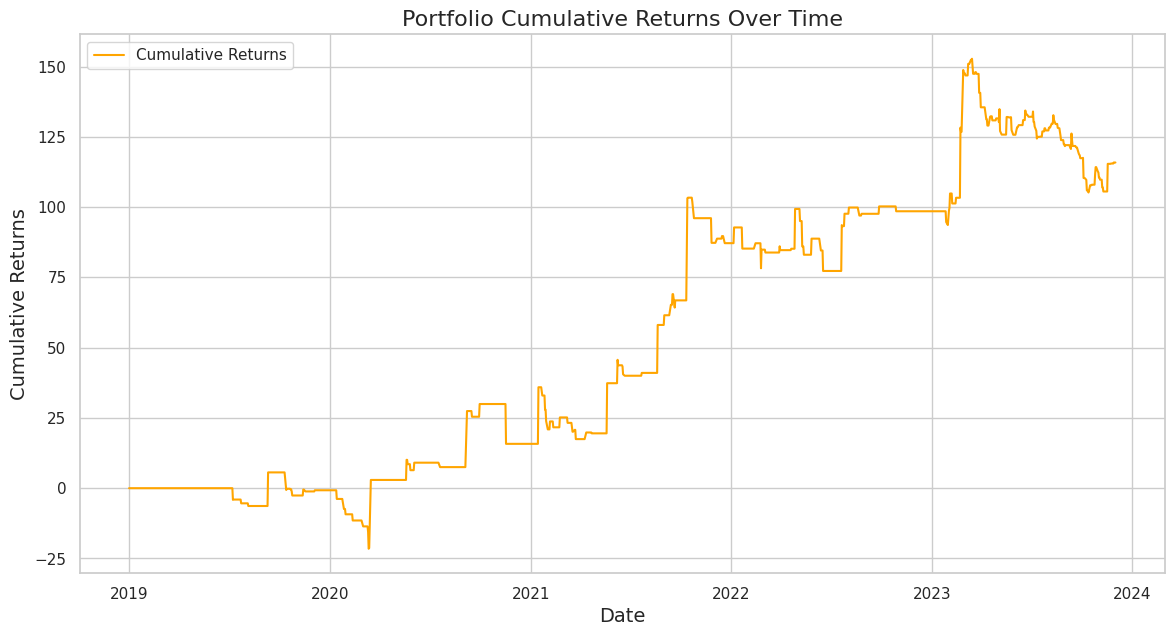

In [ ]:
# Calculate the daily returns of the portfolio
daily_returns = portfolio_df['Portfolio Value'].pct_change()

# Calculate the cumulative returns of the portfolio
cumulative_returns = (portfolio_df['Portfolio Value']/ portfolio_df['Portfolio Value'].iloc[0] - 1)*100

# Plot the cumulative returns over time
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label='Cumulative Returns', color='orange')

# Add title and labels
plt.title('Portfolio Cumulative Returns Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

# Add legend
plt.legend()

# Show the plot
plt.show()


COMPARISION TO A NIFTY 50

[*********************100%***********************]  1 of 1 completed


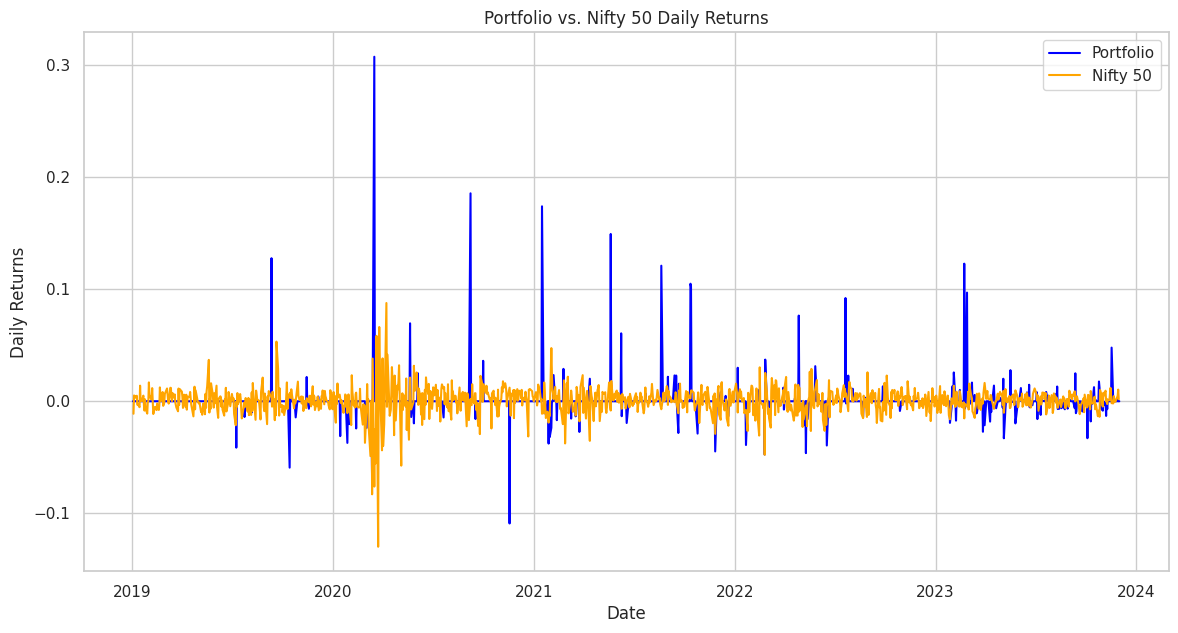

In [ ]:
import yfinance as yf

# Define the Nifty 50 ticker symbol
nifty_50 = '^NSEI'

# Download historical data for Nifty 50 from 2019-01-01 to 2023-12-01
nifty_data = yf.download(nifty_50, start="2019-01-01", end="2023-12-01")

nifty_data['Returns'] = nifty_data['Close'].pct_change()
daily_returns = portfolio_df['Portfolio Value'].pct_change()

# Drop any NaN values (first day will have NaN return since there's no previous day)
nifty_returns_list = nifty_data['Returns'].dropna().tolist()
plt.figure(figsize=(14, 7))
plt.plot(daily_returns, label="Portfolio", color='blue')
plt.plot(nifty_data['Returns'], label="Nifty 50", color='orange')
plt.legend()
plt.title("Portfolio vs. Nifty 50 Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Returns")
plt.show()


TRADE LEVEL ANALYSIS